In [ ]:
# Mount Google Drive (If using Colab)

from google.colab import drive
drive.mount("drive")

In [35]:
# Install Required Libraries from PyPI

!pip install git+https://github.com/hukkelas/DSFD-Pytorch-Inference.git
!pip install tqdm

  Cloning https://github.com/hukkelas/DSFD-Pytorch-Inference.git to c:\users\shiyou\appdata\local\temp\pip-req-build-irtcsz5e
  Resolved https://github.com/hukkelas/DSFD-Pytorch-Inference.git to commit 2bdd997d785e20ea39a911e9b3c451b7cdd3b152


  Running command git clone -q https://github.com/hukkelas/DSFD-Pytorch-Inference.git 'C:\Users\ShiYou\AppData\Local\Temp\pip-req-build-irtcsz5e'


In [2]:
# Import Required Libraries

import os
import numpy as np
import cv2
import face_detection
import tensorflow 
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.layers import Dense,Dropout,AveragePooling2D,Flatten
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import tqdm
# from google.colab.patches import cv2_imshow

In [3]:
# Initialize a Face Detector 
# Confidence Threshold can be Adjusted, Greater values would Detect only Clear Faces

detector = face_detection.build_detector("DSFDDetector", confidence_threshold=.5, nms_iou_threshold=.3)

## BLURRING AUGMENTATION ##

In [23]:
# Define Blurring Kernel Size Ranges, a Random Size would be chosen in the Specified Ranges
# Greater the Size, Higher is the Blurring Effect (Adjustments can be made according to the needs)

motion_blur_kernel_range = (4,8)  
average_blur_kernel_range = (3,7)
gaussian_blur_kernel_range = (3,8)

In [24]:
# Set Blurring Kernels to Use and their associated Probabilities

Blurring_Kernels = ["none","motion","gaussian","average"]
Probs = [0.75,0.1,0.05,0.1]

In [25]:
# Add Motion Blur to an Image in a Random Direction

def motion_blur(img):

  # Choose a Random Kernel Size
  kernel_size = np.random.randint(motion_blur_kernel_range[0],motion_blur_kernel_range[1])
  kernel = np.zeros((kernel_size, kernel_size))

  # Random Selection of Direction of Motion Blur
  types = ["vertical","horizontal","main_diagonal","anti_diagonal"]
  choice = np.random.choice(types)

  if choice=="vertical":
    kernel[:,int((kernel_size-1)/2)] = np.ones(kernel_size)/kernel_size
  
  elif choice=="horizontal":
    kernel[int((kernel_size-1)/2),:] = np.ones(kernel_size)/kernel_size
  
  elif choice=="main_diagonal":
    
    for i in range(kernel_size):
      kernel[i][i] = 1/kernel_size

  elif choice=="anti_diagonal":

    for i in range(kernel_size):
      kernel[i][kernel_size-i-1] = 1/kernel_size

  # Convolve and Return the Blurred Image
  return cv2.filter2D(img,-1,kernel)

In [26]:
# Add a Random Blur Effect to an Image with a Random Kernel Size (in the Specified Ranges)
from tensorflow.keras.applications.resnet50 import preprocess_input

def get_blurred_picture(img):
  
  # Randomly choose a Blurring Technique
  choice = np.random.choice(Blurring_Kernels,p=Probs)

  # RGB to BGR for OpenCV
  img = img[:,:,::-1]

  if choice=="none":

    random_blurred_img = img

  elif choice=="motion":
  
    random_blurred_img  = motion_blur(img)

  elif choice=="gaussian":

    kernel_size = np.random.randint(gaussian_blur_kernel_range[0],gaussian_blur_kernel_range[1])

    if kernel_size%2==0:
      kernel_size-=1
    
    random_blurred_img = cv2.GaussianBlur(img,(kernel_size,kernel_size),0)

  elif choice=="average":
  
    kernel_size = np.random.randint(average_blur_kernel_range[0],average_blur_kernel_range[1])
    random_blurred_img = cv2.blur(img,(kernel_size,kernel_size))

  # PreProcess for ResNet50
  preprocessed = preprocess_input(random_blurred_img[:,:,::-1])
  
  return preprocessed 

## TRAINING ##

In [5]:
# Load Pretrained ResNet50 Model (without Last few Layers) 
# Freeze all the Layers

base_network  = ResNet50(input_shape = (224,224,3),weights='imagenet',include_top=False)
for layer in base_network.layers:
  layer.trainaibale = False

In [6]:
# Define the Face Mask Classifier Model by adding a few Layers on top of the ResNet50 Pretrained Model

classifier_network = base_network.output
classifier_network = AveragePooling2D(pool_size=(7, 7),name = "Average_Pool_Final")(classifier_network)
classifier_network = Flatten(name = "Flatten_Final")(classifier_network)
classifier_network = Dense(128, activation="relu",name = "Dense_Final")(classifier_network)
classifier_network = Dropout(0.5,name = "Dropout_Final")(classifier_network)
classifier_network = Dense(1, activation="sigmoid", name = "Sigmoid_Classifier" )(classifier_network)

mask_classifier = Model(inputs=base_network.input, outputs=classifier_network)

In [7]:
# Set Path to the Dataset
# Faces would be extracted and placed in the specified Directory after Processing

Dataset_PATH = r"C:\Users\ShiYou\Desktop\Sem 7\WID3008 Image Processing\Assignment\Social_Distancing_with_AI\dataset\training_data"
Processed_Dataset_PATH = r"C:\Users\ShiYou\Desktop\Sem 7\WID3008 Image Processing\Assignment\Social_Distancing_with_AI\dataset\processed_data"

In [45]:
# Prepare the Data for Training 
# Extract Faces from the Dataset and Save them in the specified Directory

# There should be 2 Sub-Directories corresponding to Masked and Non-Masked Faces
paths = ["with_mask","without_mask"]

for path in paths:

  curr_path = os.path.join(Dataset_PATH,path)
  
  # Loop through all Images
  for file_name in tqdm.notebook.tqdm(os.listdir(curr_path)):

    try:
      
      image = cv2.imread(os.path.join(curr_path,file_name))

      # Detect Faces, Crop and Save
      detections = detector.detect(image[:,:,::-1])

      for j in range(len(detections)):
    
        face = image[int(detections[j][1]):int(detections[j][3]),
                     int(detections[j][0]):int(detections[j][2])]
        
        cv2.imwrite(os.path.join(Processed_Dataset_PATH,path)+"/"+file_name,face)
    
    except:
      continue

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\ShiYou\\Desktop\\Sem 7\\WID3008 Image Processing\\Assignment\\Social_Distancing_with_AI\\dataset\\training_data\\with_mask'

In [15]:
# Set the Hyper-Parameters

alpha = 0.00001
n_epochs = 5
mini_batch_size = 32

In [16]:
# Compile the Model

opt = Adam(learning_rate=alpha,decay = alpha/n_epochs)
mask_classifier.compile(optimizer=opt,loss="binary_crossentropy",metrics = ['accuracy'])

In [17]:
# Define a ImageDataGenerator for Real-Time Data Augmentation
# Parameters can be Tuned for controlling the Augmentation

Data_Generator = ImageDataGenerator(horizontal_flip=True,
                                    brightness_range=[0.5,1.25],
                                    zoom_range=[0.8,1],
                                    rotation_range = 15)

In [18]:
# Create a Data_Generator Instance

Train_Data_Generator = Data_Generator.flow_from_directory(Processed_Dataset_PATH,target_size=(224,224),
                                                          class_mode="binary",batch_size=mini_batch_size)

Found 7553 images belonging to 2 classes.


In [19]:
# Train the Model

mask_classifier.fit(x=Train_Data_Generator,
                    steps_per_epoch=(Train_Data_Generator.n//mini_batch_size),
                    epochs=n_epochs)

Epoch 1/5
 36/236 [===>..........................] - ETA: 4:56 - loss: 0.6568 - accuracy: 0.6406

C:\Users\ShiYou\anaconda3\envs\ML\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


236/236 [==============================] - 273s 1s/step - loss: 0.2487 - accuracy: 0.8926
Epoch 2/5
236/236 [==============================] - 60s 253ms/step - loss: 0.0477 - accuracy: 0.9863
Epoch 3/5
236/236 [==============================] - 60s 255ms/step - loss: 0.0255 - accuracy: 0.9923
Epoch 4/5
236/236 [==============================] - 63s 266ms/step - loss: 0.0166 - accuracy: 0.9956
Epoch 5/5
236/236 [==============================] - 61s 256ms/step - loss: 0.0112 - accuracy: 0.9973


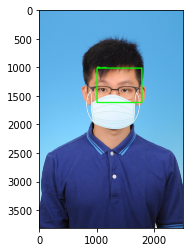

In [38]:
# Test the Model on a Picture
import matplotlib.pyplot as plt

FILE_PATH = r"C:\Users\ShiYou\Desktop\Sem 7\WID3008 Image Processing\Assignment\Social_Distancing_with_AI\shiyou2.jpg"

img = cv2.imread(FILE_PATH)
masked_faces = []
unmasked_faces = []
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Detect Faces
detections = detector.detect(img[:,:,::-1])

if detections.shape[0]>0:
      
  for i in range(detections.shape[0]):
  
    # Get Co-ordinates
    x1 = int(detections[i][0])
    x2 = int(detections[i][2])
    y1 = int(detections[i][1])
    y2 = int(detections[i][3])

    # Predict Output
    face_arr = cv2.resize(img[y1:y2,x1:x2,::-1], (224, 224), interpolation=cv2.INTER_NEAREST)
    face_arr = np.expand_dims(face_arr, axis=0)
    face_arr = preprocess_input(face_arr)
    match = mask_classifier.predict(face_arr)

    if match[0][0]<0.5:
      masked_faces.append([x1,y1,x2,y2])
    else:
      unmasked_faces.append([x1,y1,x2,y2])

# Put Bounding Box on the Faces (Green:Masked,Red:Not-Masked)
for f in range(len(masked_faces)):
    a,b,c,d = masked_faces[f]
    cv2.rectangle(img, (a,b), (c,d), (0,255,0), 20)
    cv2.putText(img, 'With_mask', (a,b),cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,0), 10)

for f in range(len(unmasked_faces)):
    a,b,c,d = unmasked_faces[f]
    img = cv2.rectangle(img, (a,b), (c,d), (255,0,0), 10)
    cv2.putText(img, 'No_mask', (a,b-10),cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,0,0), 10)
    

# Show Results
plt.imshow(img)
plt.show()

In [24]:
# Save the Trained Weights to Disk

SAVE_PATH = r"C:\Users\ShiYou\Desktop\Sem 7\WID3008 Image Processing\Assignment\Social_Distancing_with_AI\ResNet50_Classifier.h5"
mask_classifier.save(SAVE_PATH)

C:\Users\ShiYou\anaconda3\envs\ML\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
